# Recommendation System

In [36]:
from collections import Counter

import pandas as pd
import numpy as np

import pickle as pk

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from jupyterthemes import jtplot
jtplot.style(figsize=(15, 9))

## Data

### Movies

In [2]:
movies = pd.read_csv('../data/popular_10000_movies/movies_dataset_CLEAN.csv', index_col='id')
movies.head()

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
385687,"[28, 80, 53]",Over many missions and against impossible odds...,4654.279,2023-05-17,Fast X,7.3,2093,"Action, Crime, Thriller","[{'cast_id': 12835, 'name': 'Vin Diesel', 'cha...","[{'crew_id': 1302, 'name': 'Susie Figgis', 'de...","[{'id': 9663, 'name': 'sequel'}, {'id': 9748, ..."
697843,"[28, 53]",Tasked with extracting a family who is at the ...,2494.010,2023-06-09,Extraction 2,7.7,910,"Action, Thriller","[{'cast_id': 74568, 'name': 'Chris Hemsworth',...","[{'crew_id': 950, 'name': 'Pietro Scalia', 'de...","[{'id': 3070, 'name': 'mercenary'}, {'id': 966..."
603692,"[28, 53, 80]","With the price on his head ever increasing, Jo...",1920.127,2023-03-22,John Wick: Chapter 4,7.9,3344,"Action, Thriller, Crime","[{'cast_id': 6384, 'name': 'Keanu Reeves', 'ch...","[{'crew_id': 3615, 'name': 'Manfred Banach', '...","[{'id': 242, 'name': 'new york city'}, {'id': ..."
569094,"[28, 12, 16, 878]","After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'cast_id': 587506, 'name': 'Shameik Moore', ...","[{'crew_id': 7624, 'name': 'Stan Lee', 'depart...","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
502356,"[16, 10751, 12, 14, 35]","While working underground to fix a water main,...",1539.037,2023-04-05,The Super Mario Bros. Movie,7.8,5165,"Animation, Family, Adventure, Fantasy, Comedy","[{'cast_id': 73457, 'name': 'Chris Pratt', 'ch...","[{'crew_id': 70851, 'name': 'Jack Black', 'dep...","[{'id': 282, 'name': 'video game'}, {'id': 690..."


In [3]:
movies = movies[['popularity', 'release_date', 'title', 'vote_average', 'vote_count']]
movies.head()

,popularity,release_date,title,vote_average,vote_count
id,,,,,
385687,4654.279,2023-05-17,Fast X,7.3,2093
697843,2494.010,2023-06-09,Extraction 2,7.7,910
603692,1920.127,2023-03-22,John Wick: Chapter 4,7.9,3344
569094,2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796
502356,1539.037,2023-04-05,The Super Mario Bros. Movie,7.8,5165


In [4]:
movies.dtypes

popularity      float64
release_date     object
title            object
vote_average    float64
vote_count        int64
dtype: object

### Genres: cosine similarity and one-hot labeling

In [8]:
genres_cs = pd.read_csv('data/genres_cosine_similarity.csv', index_col=0)
genres_cs

,TV Movie,Thriller,Action,Mystery,Crime,Documentary,Adventure,Science Fiction,Drama,Animation,Music,Fantasy,Family,Romance,Western,War,History,Horror,Comedy
TV Movie,1.000000,0.394733,0.513236,0.396730,0.364897,0.273702,0.592527,0.535230,0.511371,0.599006,0.580721,0.615960,0.676505,0.495483,0.354297,0.326719,0.332524,0.410583,0.677208
Thriller,0.394733,1.000000,0.717784,0.803086,0.803562,0.252943,0.478655,0.632004,0.747659,0.276127,0.261950,0.419476,0.280956,0.495854,0.468874,0.527351,0.504018,0.717057,0.440748
Action,0.513236,0.717784,1.000000,0.554684,0.650536,0.291962,0.797106,0.781199,0.623967,0.589238,0.364484,0.625936,0.571553,0.473524,0.555539,0.573059,0.479258,0.612385,0.641312
Mystery,0.396730,0.803086,0.554684,1.000000,0.702164,0.263122,0.456686,0.554591,0.662259,0.365163,0.314863,0.449878,0.368790,0.471931,0.387748,0.379926,0.384377,0.646352,0.491783
Crime,0.364897,0.803562,0.650536,0.702164,1.000000,0.289151,0.422055,0.450467,0.701130,0.281047,0.310511,0.349360,0.297321,0.481107,0.460968,0.420063,0.462907,0.507797,0.503363
Documentary,0.273702,0.252943,0.291962,0.263122,0.289151,1.000000,0.247916,0.216827,0.337446,0.169529,0.257017,0.192158,0.198267,0.221919,0.214639,0.240606,0.312933,0.220365,0.274301
Adventure,0.592527,0.478655,0.797106,0.456686,0.422055,0.247916,1.000000,0.719617,0.537524,0.801408,0.530574,0.794288,0.831916,0.530338,0.534050,0.451217,0.386237,0.464983,0.784823
Science Fiction,0.535230,0.632004,0.781199,0.554591,0.450467,0.216827,0.719617,1.000000,0.512783,0.598825,0.354121,0.613756,0.575048,0.428716,0.385528,0.382743,0.295121,0.641385,0.601664
Drama,0.511371,0.747659,0.623967,0.662259,0.701130,0.337446,0.537524,0.512783,1.000000,0.351065,0.497333,0.496137,0.432878,0.725442,0.603654,0.706889,0.748685,0.516213,0.542533
Animation,0.599006,0.276127,0.589238,0.365163,0.281047,0.169529,0.801408,0.598825,0.351065,1.000000,0.590689,0.775147,0.926371,0.421453,0.339857,0.239284,0.198830,0.339585,0.789651


In [6]:
genres_oh = pd.read_csv('data/one-hot_genres.csv', index_col='id')
genres_oh.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,
385687,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
697843,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
603692,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
569094,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
502356,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [7]:
genres_oh.loc[movies.index]

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,
385687,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
697843,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
603692,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
569094,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
502356,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15017,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
79509,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
13370,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [8]:
genres_oh = genres_oh[~genres_oh.index.duplicated(keep='first')]

In [9]:
genres_oh.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,
385687,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
697843,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
603692,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
569094,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
502356,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [10]:
genres_oh.shape, movies.shape

((9939, 19), (9144, 5))

### Keywords

In [7]:
keywords = pd.read_csv('data/keywords_list.csv', index_col='id')
keywords.head()

,keywords_list
id,
385687,"['sequel', 'revenge', 'racing', 'family', 'cars']"
697843,"['mercenary', 'sequel', 'rescue mission', 'lon..."
603692,"['new york city', 'martial arts', 'hitman', 's..."
569094,"['sacrifice', 'villain', 'comic book', 'sequel..."
502356,"['video game', 'gorilla', 'plumber', 'magic mu..."


In [12]:
keywords.shape

(9144, 1)

In [13]:
with open('data/keywords_counter.pickle', 'rb') as f:
    keywords_counter = pk.load(f)

In [14]:
len(keywords_counter)

14239

In [2]:
unique_keywords = pd.read_csv('data/unique_keywords_genres_count_with_labels_SHORTED_VERSION_label_encoder.csv', index_col=0)
unique_keywords.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,label,label_encoder
car crash,20,10,1,16,11,0,15,4,5,0,...,1,6,3,9,1,25,0,0,Thriller,233
liposuction,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,"Comedy, Drama, Fantasy",82
stasis,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,Science Fiction,231
giant vegetable,0,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Animation,63
monster,48,43,22,41,0,0,17,27,50,0,...,1,12,0,55,8,29,1,0,Horror,204


### Cast

In [14]:
cast = pd.read_csv('data/cast_list.csv', index_col='id')
cast.head()

,cast_list
id,
385687,"['Vin Diesel', 'Michelle Rodriguez', 'Tyrese G..."
697843,"['Chris Hemsworth', 'Golshifteh Farahani', 'Ad..."
603692,"['Keanu Reeves', 'Donnie Yen', 'Bill Skarsgård..."
569094,"['Shameik Moore', 'Hailee Steinfeld', 'Brian T..."
502356,"['Chris Pratt', 'Anya Taylor-Joy', 'Charlie Da..."


In [15]:
cast.shape

(9133, 1)

In [3]:
unique_actors = pd.read_csv('data/unique_actors_genres_count_with_labels_SHORTED_VERSION_label_encoder.csv', index_col=0)
unique_actors.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,label,label_encoder
Sheldon Jett,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,"Comedy, Romance, Action",138
Jocelyn Ott,0,1,0,1,0,0,1,1,1,0,...,0,0,1,0,0,0,0,0,"Adventure, Comedy, Drama",61
Mel Archer,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,"Drama, Western, Action",253
Tony Aitken,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,"Drama, Romance, Action",234
J.K. Simmons,24,24,12,31,9,2,30,12,9,4,...,3,2,9,12,1,14,0,3,"Comedy, Drama, Action",117


## Hey, beauty, what do you want to watch tonight?

In [4]:
movies_full = pd.read_csv('../data/popular_10000_movies/movies_dataset_CLEAN.csv', index_col='id')

In [5]:
something_like = movies_full[movies_full['title'].isin(['Starship Troopers', 'Aliens', 'Pitch Black'])]
something_like

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
679,"[28, 53, 878]",When Ripley's lifepod is found by a salvage cr...,59.005,1986-07-18,Aliens,7.9,8542,"Action, Thriller, Science Fiction","[{'cast_id': 10205, 'name': 'Sigourney Weaver'...","[{'crew_id': 8380, 'name': 'Michael Lamont', '...","[{'id': 803, 'name': 'android'}, {'id': 1603, ..."
563,"[12, 28, 53, 878]","Set in the future, the story follows a young s...",28.171,1997-11-07,Starship Troopers,7.0,4268,"Adventure, Action, Thriller, Science Fiction","[{'cast_id': 27763, 'name': 'Casper Van Dien',...","[{'crew_id': 3686, 'name': 'Johanna Ray', 'dep...","[{'id': 305, 'name': 'moon'}, {'id': 818, 'nam..."
2787,"[53, 878, 28]",When their ship crash-lands on a remote planet...,14.899,2000-02-18,Pitch Black,6.8,3974,"Thriller, Science Fiction, Action","[{'cast_id': 12835, 'name': 'Vin Diesel', 'cha...","[{'crew_id': 2214, 'name': 'Paul Haslinger', '...","[{'id': 3762, 'name': 'darkness'}, {'id': 4565..."


In [39]:
print('Aliens:')
print(keywords.loc[679].to_list()[0])

Aliens:
['android', 'extraterrestrial technology', 'space marine', 'spaceman', 'cryogenics', 'vacuum', 'space colony', 'warrior woman', 'settler', 'space travel', 'colony', 'space', 'alien', 'creature', 'desolate', 'xenomorph', 'desolate planet']


In [40]:
print('Starship Troopers:')
print(keywords.loc[563].to_list()[0])

Starship Troopers:
['moon', 'based on novel or book', 'asteroid', 'spacecraft', 'space marine', 'intelligence', 'buenos aires, argentina', 'space battle', 'dystopia', 'army', 'giant insect', 'satire', 'creature', 'soldier', 'drill instructor', 'military', 'bugs']


In [41]:
print('Pitch Black:')
print(keywords.loc[2787].to_list()[0])

Pitch Black:
['darkness', 'dystopia', 'comet', 'alien life-form', 'survival', 'creature', 'eclipse', 'flask', 'spaceship crash']


In [77]:
max(len(keywords_counter['android'].keys()), len(keywords_counter['moon'].keys()), len(keywords_counter['darkness'].keys()))

304

In [10]:
genres_choice = something_like['genres'].to_list()
genres_choice

['Action, Thriller, Science Fiction',
 'Adventure, Action, Thriller, Science Fiction',
 'Thriller, Science Fiction, Action']

In [20]:
genres_flat_list = [g for gs in genres_choice for g in gs.split(', ')]

In [22]:
genres_cs.loc[list(set(genres_flat_list)), list(set(genres_flat_list))]

,Action,Adventure,Thriller,Science Fiction
Action,1.000000,0.797106,0.717784,0.781199
Adventure,0.797106,1.000000,0.478655,0.719617
Thriller,0.717784,0.478655,1.000000,0.632004
Science Fiction,0.781199,0.719617,0.632004,1.000000


Text(0.5, 1.0, 'Correlation of genres of chosen films')

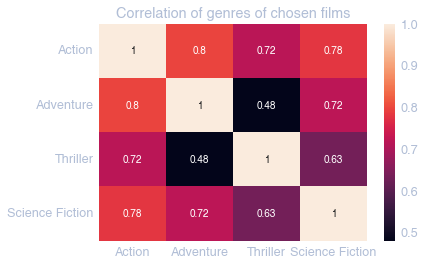

In [23]:
plt.figure()
sns.heatmap(genres_cs.loc[list(set(genres_flat_list)), list(set(genres_flat_list))], annot=True)
plt.title('Correlation of genres of chosen films')

In [39]:
unique_keywords.loc[keywords.loc[679].to_list()[0][2:-2].split("', '")]

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,label,label_encoder
android,18,15,2,7,4,0,8,0,1,0,...,0,4,2,43,0,17,0,1,Science Fiction,231
extraterrestrial technology,4,5,2,2,0,0,6,6,2,0,...,0,4,0,15,0,6,0,0,Science Fiction,231
space marine,18,18,5,8,1,0,2,7,3,0,...,0,4,0,32,1,10,0,0,Science Fiction,231
spaceman,1,1,0,0,0,0,1,0,0,1,...,0,1,1,2,0,2,0,0,Science Fiction,231
cryogenics,3,1,1,0,2,0,1,0,1,0,...,0,1,1,5,0,1,0,0,Science Fiction,231
vacuum,1,0,1,0,0,0,0,0,0,0,...,0,0,0,2,0,2,0,0,Science Fiction,231
space colony,6,5,0,0,0,0,1,0,1,0,...,0,0,1,7,0,1,0,0,Science Fiction,231
warrior woman,6,4,1,0,0,0,1,1,2,1,...,0,0,0,1,0,2,0,0,"Action, Adventure, Fantasy",3
settler,2,2,0,1,0,0,4,0,0,0,...,0,0,2,1,0,1,0,9,"Western, Drama, Action",248
space travel,26,28,6,6,0,0,11,5,5,2,...,0,5,2,47,2,12,0,0,Science Fiction,231


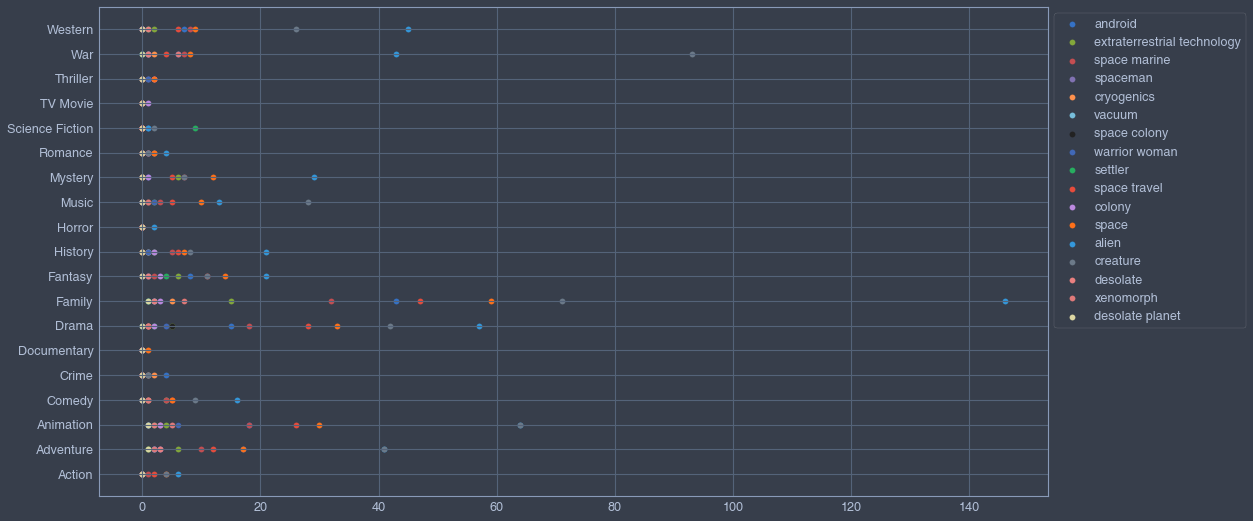

In [98]:
x = keywords.loc[679].to_list()[0][2:-2].split("', '")
y = np.arange(19)

fig, ax = plt.subplots(figsize=(17, 9))

for keyword in x:
    ax.scatter(unique_keywords.loc[keyword, genres_cs.index.to_list()].to_list(), y, label=keyword)
    
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.yaxis.set_ticks(y)
ax.set_yticklabels(unique_keywords.columns.to_list()[:-2]);

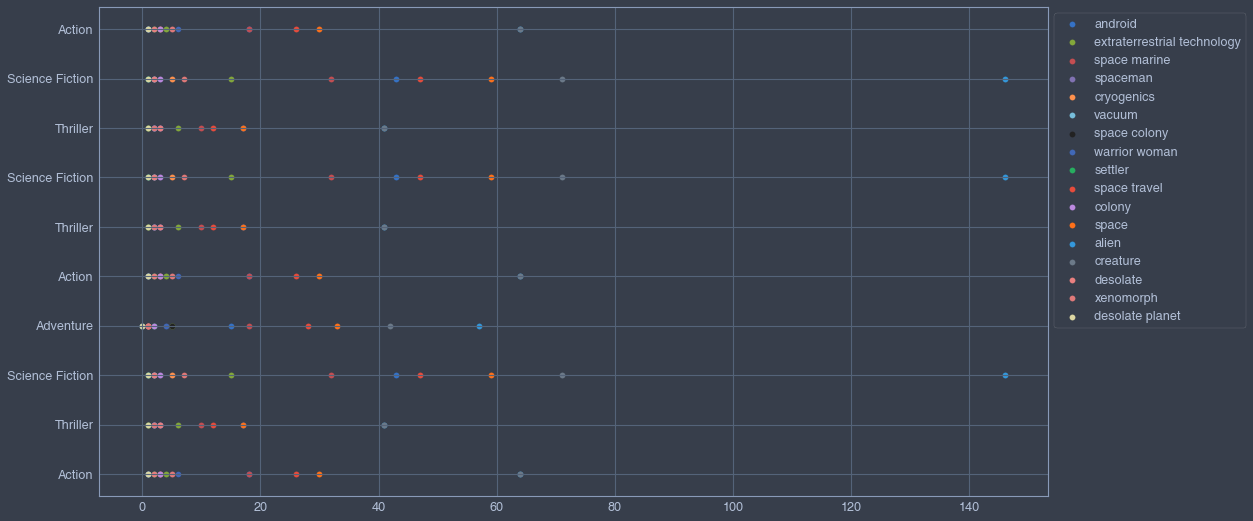

In [97]:
y = np.arange(0, len(genres_flat_list))

fig, ax = plt.subplots(figsize=(17, 9))

for keyword in x:
    ax.scatter(unique_keywords.loc[keyword, genres_flat_list].to_list(), y, label=keyword)
    
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.yaxis.set_ticks(y)
ax.set_yticklabels(genres_flat_list);